In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn

np.random.seed(12345)

In [2]:
nb_inputs  = 60
nb_hidden  = 30
nb_outputs = 2

time_step = 1e-3
nb_steps  = 120

batch_size = 128

dtype = torch.float
device = torch.device("cpu")

# Uncomment the line below to run on GPU
# device = torch.device("cuda:0") 

In [3]:
pop_xor = np.loadtxt("pop_xor_remapped.data")
pop_xor[:, 1] = np.rint(4e3*pop_xor[:,1])  # use times up to 100µs instead of 10ms
pop_xor = pop_xor.astype(int)
pop_xor[:, 0] -= 1  # start at zero until 95
pop_xor_spiketrains = {0: (pop_xor[:20], 0),
                       1: (pop_xor[20:60], 1),
                       2: (pop_xor[60:100], 1),
                       3: (pop_xor[100:160], 0)}

y_data = torch.zeros(batch_size, device=device, dtype=int, requires_grad=False)
x_data = torch.zeros((batch_size, nb_steps, nb_inputs), device=device, dtype=dtype, requires_grad=False)
random_patterns = np.random.randint(0,4, batch_size)
for b, target in enumerate(random_patterns):
    nrn_id = pop_xor_spiketrains[target][0][:,0]
    spike_time = pop_xor_spiketrains[target][0][:,1]
    x_data[b, spike_time, nrn_id] = 1 
    y_data[b] = int(pop_xor_spiketrains[target][1])

If the plot the spike raster of the first input pattern, this synthetic dataset looks as follows.

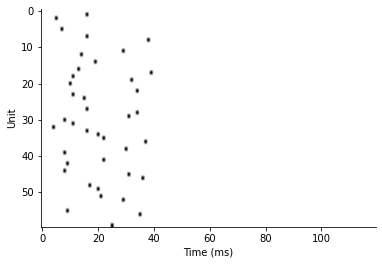

In [30]:
data_id = 0
plt.imshow(x_data[data_id].cpu().t(), cmap=plt.cm.gray_r, aspect="auto")
plt.xlabel("Time (ms)")
plt.ylabel("Unit")
sns.despine()

In [31]:
tau_mem = 10e-3
tau_syn = 5e-3
tau_eps = 10e-3
alpha   = float(np.exp(-time_step/tau_syn))
eps     = float(np.exp(-time_step/tau_eps))
beta    = float(np.exp(-time_step/tau_mem))

In [32]:
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


In [33]:
def spike_fn(x):
    out = torch.zeros_like(x)
    out[x > 0] = 1.0
    return out

In [34]:
syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

# Here we define two lists which we use to record the membrane potentials and output spikes
mem_rec = [mem]
spk_rec = [mem]

# activation of hidden layer
h1 = torch.einsum("abc,cd->abd", (x_data, w1))

# Here we loop over time
for t in range(nb_steps):
    mthr = mem-1.0
    out = spike_fn(mthr)
    rst = torch.zeros_like(mem)
    c = (mthr > 0)
    rst[c] = torch.ones_like(mem)[c]
    
    new_syn = alpha*syn +h1[:,t]
    new_mem = beta*mem +syn -rst
    
    mem = new_mem
    syn = new_syn
    
    mem_rec.append(mem)
    spk_rec.append(out)

# Now we merge the recorded membrane potentials into a single tensor
mem_rec = torch.stack(mem_rec,dim=1)
spk_rec = torch.stack(spk_rec,dim=1)

In [35]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=5):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = (mem+spike_height*spk).detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")
        
def plot_single_traces(trace, spk=None, spike_height=5, ax=None, title=None):
    if ax is None:
        ax = plt.gca()
    if title is not None:
        ax.set_title(title)
    if spk is not None:
        dat = (trace+spike_height*spk).detach().cpu().numpy()
    else:
        dat = trace.detach().cpu().numpy()
    ax.plot(dat[0])

def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    syn = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    mem_rec = [mem]
    spk_rec = [mem]

    # Compute hidden layer activity
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c   = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]

        new_syn = alpha*syn +h1[:,t]
        new_mem = beta*mem +syn -rst

        mem = new_mem
        syn = new_syn

        mem_rec.append(mem)
        spk_rec.append(out)

    mem_rec = torch.stack(mem_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2 = torch.einsum("abc,cd->abd", (spk_rec, w2))
    syn = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    mem = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    spk_o_rec = [out]
    mem_o_rec = [mem]
    for t in range(nb_steps):
        mthr = mem-1.0
        out = spike_fn(mthr)
        rst = torch.zeros_like(mem)
        c   = (mthr > 0)
        rst[c] = torch.ones_like(mem)[c]
        
        new_syn = alpha*syn +h2[:,t]
        new_mem = beta*mem +syn -rst
        
        mem = new_mem
        syn = new_syn
        
        spk_o_rec.append(out)
        mem_o_rec.append(mem)

    spk_o_rec = torch.stack(spk_o_rec,dim=1)
    mem_o_rec = torch.stack(mem_o_rec, dim=1)
    out_recs = [mem_o_rec, spk_o_rec]
    other_recs = [mem_rec, spk_rec]
    return out_recs, other_recs

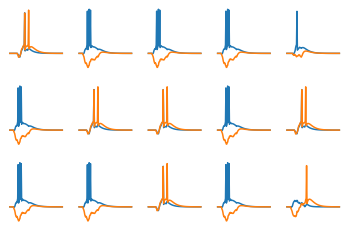

In [36]:
out_rec,other_recs = run_snn(x_data)
plot_voltage_traces(*out_rec)

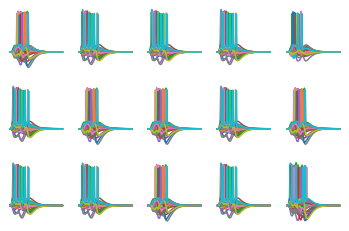

In [37]:
plot_voltage_traces(*other_recs)

In [38]:
def classification_acc():
    output,_ = run_snn(x_data)
    m,_= torch.max(output[0],1) # max over time
    _,am=torch.max(m,1) # argmax over output units
    return np.mean((y_data==am).detach().cpu().numpy()) # compare to labels
def print_classification_accuracy():
    """ Dirty little helper function to compute classification accuracy. """
    acc = classification_acc()
    print("Accuracy %.3f"%acc)
    
print_classification_accuracy()

Accuracy 0.469


### Supervised learning with the true gradient

In [39]:
w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

params = [w1,w2] # The paramters we want to optimize
optimizer = torch.optim.Adam(params, lr=8e-4, betas=(0.9,0.999)) # The optimizer we are going to use

log_softmax_fn = nn.LogSoftmax(dim=1) # The log softmax function across output units
loss_fn = nn.NLLLoss() # The negative log likelihood loss function

# The optimization loop
loss_hist = []
for e in range(400):
    # run the network and get ou't'put
    output,_ = run_snn(x_data) 
    # compute the loss
    m,_=torch.max(output[0],1)
    log_p_y = log_softmax_fn(m) 
    loss_val = loss_fn(log_p_y, y_data)
    
    # update the weights
    optimizer.zero_grad()
    loss_val.backward()
    
    optimizer.step()
    # store loss value
    loss_hist.append(loss_val.item())
    if e % 10 == 0:
        print("%s/100" % e, np.round(loss_val.item(),3), "class %s/100 %%" % np.round(100*classification_acc(),1))

print(w2.grad)
print(w2.grad.shape)
loss_hist_true_grad = loss_hist # store for later use

0/100 0.756 class 46.1/100 %
10/100 0.723 class 46.1/100 %
20/100 0.723 class 73.4/100 %
30/100 0.701 class 73.4/100 %
40/100 0.686 class 46.1/100 %
50/100 0.649 class 73.4/100 %
60/100 0.64 class 73.4/100 %
70/100 0.622 class 73.4/100 %
80/100 0.597 class 73.4/100 %
90/100 0.568 class 73.4/100 %
100/100 0.575 class 73.4/100 %
110/100 0.578 class 73.4/100 %
120/100 0.551 class 73.4/100 %
130/100 0.573 class 73.4/100 %
140/100 0.539 class 73.4/100 %
150/100 0.524 class 100.0/100 %
160/100 0.522 class 100.0/100 %
170/100 0.513 class 100.0/100 %
180/100 0.517 class 100.0/100 %
190/100 0.516 class 73.4/100 %
200/100 0.528 class 73.4/100 %
210/100 0.505 class 100.0/100 %
220/100 0.49 class 100.0/100 %
230/100 0.5 class 73.4/100 %
240/100 0.498 class 100.0/100 %
250/100 0.499 class 100.0/100 %
260/100 0.505 class 73.4/100 %
270/100 0.489 class 100.0/100 %
280/100 0.483 class 100.0/100 %
290/100 0.475 class 100.0/100 %
300/100 0.496 class 73.4/100 %
310/100 0.496 class 100.0/100 %
320/100 0.5

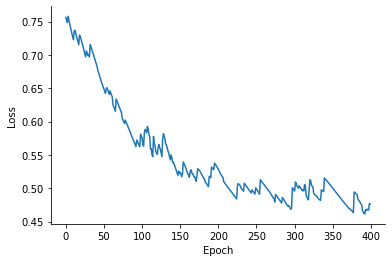

In [40]:
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [23]:
print_classification_accuracy()

Accuracy 0.531


In [41]:
time2bin = lambda x: int(np.rint(x*1e3))
bins = np.arange(nb_steps)
spk_ker = np.exp(-bins / (tau_syn*1e3))
spk_ker = spk_ker * (spk_ker > 1e-8)

def spike(tbin, spike_kernel=spk_ker, res=nb_steps+1):
    trace = np.zeros(res)
    if tbin is not None:
        trace[tbin:] = spike_kernel[:res - tbin]
    return trace

In [42]:
def get_eltr(hidden_rec, out_rec):
    # HIDDEN LAYER
    presyn = torch.zeros((batch_size,nb_inputs), device=device, dtype=dtype)
    eltr = torch.zeros((batch_size, nb_hidden, nb_inputs), device=device, dtype=dtype)
    surr = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    surrgradscale = 5
    surr_rec = [surr]
    eltr_rec = [eltr]
    mem_rec = hidden_rec[0]
    for t in range(nb_steps):
        c = (mthr > 0)
        surr = 1/(surrgradscale * torch.abs(mem_rec[:, t] - 1.0) + 1.0)**2
        surr = torch.clamp(surr, min=0.0, max = 1.0)
        
        new_presyn = alpha*presyn +  x_data[:,t]
        new_eltr = beta*eltr + torch.einsum("ab,ac->abc", (surr, new_presyn))

        presyn = new_presyn
        eltr = new_eltr

        eltr_rec.append(eltr)
        surr_rec.append(surr)

    eltr_rec = torch.stack(eltr_rec,dim=1)
    surr_rec = torch.stack(surr_rec,dim=1)

    # READOUT LAYER
    presyn_o = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    eltr_o = torch.zeros((batch_size, nb_outputs, nb_hidden), device=device, dtype=dtype)
    surr_o = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)

    surr_o_rec = [surr_o]
    eltr_o_rec = [eltr_o]
    mem_rec = out_rec[0]
    spikes = hidden_rec[1]
    for t in range(nb_steps):
        c = (mthr > 0)
        surr_o = 1/(surrgradscale * torch.abs(mem_rec[:, t] - 1.0) + 1.0)**2
        surr_o = torch.clamp(surr_o, min=0.0, max = 1.0)
        
        new_presyn_o = alpha*presyn_o +  spikes[:,t]
        new_eltr_o = beta*eltr_o + torch.einsum("ab,ac->abc", (surr_o, new_presyn_o))

        presyn_o = new_presyn_o
        eltr_o = new_eltr_o

        eltr_o_rec.append(eltr_o)
        surr_o_rec.append(surr_o)

    eltr_o_rec = torch.stack(eltr_o_rec,dim=1)
    surr_o_rec = torch.stack(surr_o_rec,dim=1)

    return eltr_rec, eltr_o_rec, surr_rec, surr_o_rec
    


In [43]:
def error(spk_rec, labels, target_window = (1,120), dflt_spk = 35):
    start, end = target_window

    # test if spikes are where they shouldnt be
    mask = torch.ones_like(spk_rec, dtype=bool, requires_grad=False)
    mask[labels.bool(), start:end, 0:1] = False
    outside_spk = -spk_rec * mask

    # there is no spike but there should be
    inside_spk = torch.zeros_like(spk_rec, requires_grad=False)
    mask = (torch.sum(spk_rec[:,start:end, 0], dim=1) < 1) & labels.bool()
    inside_spk[mask, dflt_spk, 0] = 1

    err_spk = inside_spk + outside_spk

    # convolution
    err = torch.zeros_like(spk_rec[:,0,:])
    err_rec = [err]
    for t in range(nb_steps):
        new_err = eps * err + err_spk[:,t]
        err = new_err
        err_rec.append(err)

    err_rec = torch.stack(err_rec,dim=1)
    return err_rec

In [44]:
out_rec, hidden_rec = run_snn(x_data)
eltr_rec, eltr_o_rec, surr_rec, surr_o_rec = get_eltr(hidden_rec, out_rec)

# grad and error
err_o = error(out_rec[1], y_data)
grad_o = torch.mean(torch.einsum("abdc, abd->acd", (eltr_o_rec, err_o)), dim=0)

err = torch.einsum("abd,dc->abc", (err_o, w2.T))
grad = torch.mean(torch.einsum("abdc, abd->acd", (eltr_rec, err)), dim=0)

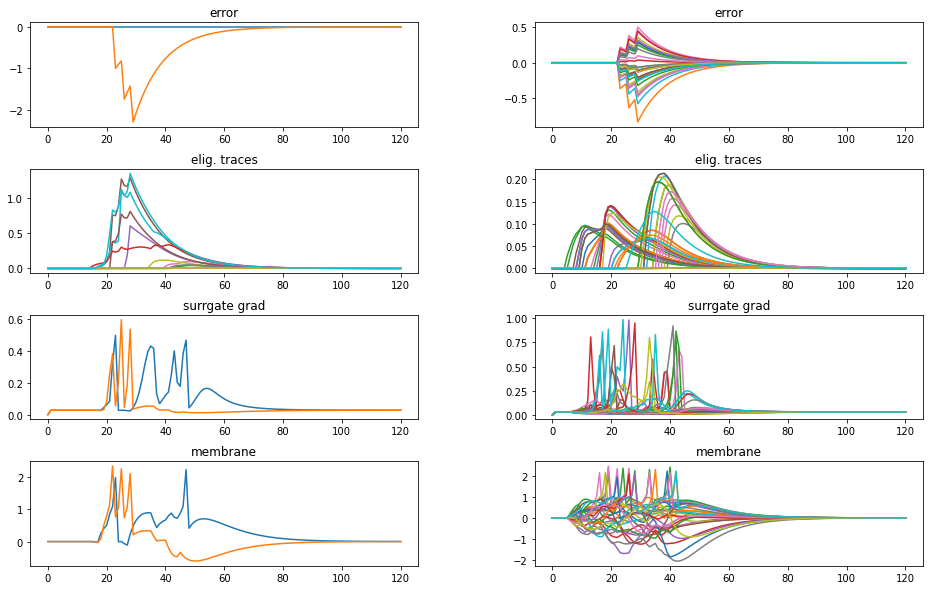

In [45]:
out_rec, hidden_rec = run_snn(x_data)
# eltr
eltr_rec, eltr_o_rec, surr_rec, surr_o_rec = get_eltr(hidden_rec, out_rec)

# error
err_o = error(out_rec[1], y_data)
err = torch.einsum("abd,dc->abc", (err_o, w2.T))

fig, axes = plt.subplots(4,2, figsize=(16,10))
idx = 0
plt.subplots_adjust(wspace=0.3, hspace=0.4)
plot_single_traces(err_o[idx:], ax=axes[0,0], title="error")
plot_single_traces(eltr_o_rec[idx:, :,1], ax=axes[1,0], title="elig. traces")
plot_single_traces(surr_o_rec[idx:], ax=axes[2,0], title="surrgate grad")
plot_single_traces(out_rec[0][idx:], out_rec[1][idx:], ax=axes[3,0], spike_height=2, title="membrane")

plot_single_traces(err[idx:], ax=axes[0,1], title="error")
plot_single_traces(eltr_rec[idx:,:,3], ax=axes[1,1], title="elig. traces")
plot_single_traces(surr_rec[idx:], ax=axes[2,1], title="surrgate grad")
plot_single_traces(other_recs[0][idx:], other_recs[1][idx:], ax=axes[3,1], spike_height=2, title="membrane")

In [47]:
np.random.seed(12345)
# The following lines will reinitialize the weights
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))
print("init done")

params = [w1,w2]
optimizer = torch.optim.SGD(params, lr=8e-4)

log_softmax_fn = nn.LogSoftmax(dim=1)
loss_fn = nn.NLLLoss()

totalloss = []
for e in range(1000):
    if e % 4 == 0:
        print("%s/40: av. loss = %s" % (e, torch.sum(torch.abs(err_o))))
    out_rec, hidden_rec = run_snn(x_data)
    
    # eltr
    eltr_rec, eltr_o_rec, surr_rec, surr_o_rec = get_eltr(hidden_rec, out_rec)

    # grad and error
    err_o = error(out_rec[1], y_data)
    grad_o = torch.mean(torch.einsum("abdc, abd->acd", (eltr_o_rec, err_o)), dim=0)

    err = torch.einsum("abd,dc->abc", (err_o, w2.T))
    grad = torch.mean(torch.einsum("abdc, abd->acd", (eltr_rec, err)), dim=0)
    
    # calculate gradients
    optimizer.zero_grad()
    w2.grad = -grad_o
    w1.grad = -grad
    optimizer.step()
    totalloss.append(torch.sum(torch.abs(err_o)))

init done
0/40: av. loss = tensor(724.9853)
4/40: av. loss = tensor(2195.7778)
8/40: av. loss = tensor(714.4280)
12/40: av. loss = tensor(714.4208)
16/40: av. loss = tensor(346.7044)
20/40: av. loss = tensor(714.4208)
24/40: av. loss = tensor(703.9147)
28/40: av. loss = tensor(714.4208)
32/40: av. loss = tensor(714.4208)
36/40: av. loss = tensor(714.4208)
40/40: av. loss = tensor(346.7044)
44/40: av. loss = tensor(714.4208)
48/40: av. loss = tensor(703.9147)
52/40: av. loss = tensor(346.7044)
56/40: av. loss = tensor(724.7535)
60/40: av. loss = tensor(703.9147)
64/40: av. loss = tensor(0.)
68/40: av. loss = tensor(0.)
72/40: av. loss = tensor(0.)
76/40: av. loss = tensor(0.)
80/40: av. loss = tensor(0.)
84/40: av. loss = tensor(0.)
88/40: av. loss = tensor(0.)
92/40: av. loss = tensor(0.)
96/40: av. loss = tensor(0.)
100/40: av. loss = tensor(0.)
104/40: av. loss = tensor(0.)
108/40: av. loss = tensor(0.)
112/40: av. loss = tensor(0.)
116/40: av. loss = tensor(0.)
120/40: av. loss = te

KeyboardInterrupt: 

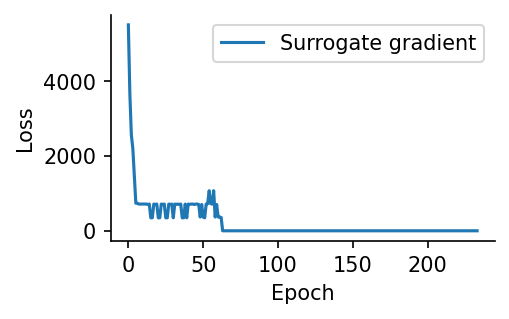

In [48]:
plt.figure(figsize=(3.3,2),dpi=150)
#plt.plot(loss_hist_true_grad, label="True gradient")
plt.plot(totalloss, label="Surrogate gradient")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
sns.despine()

In [49]:
output,other_recordings = run_snn(x_data)
mem_rec, spk_rec = other_recordings

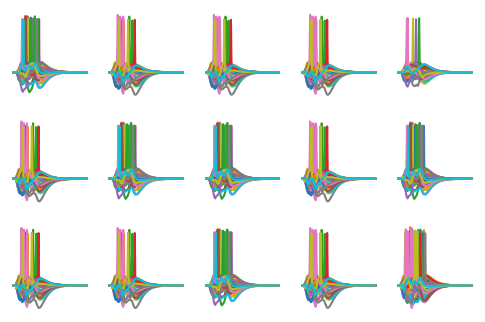

In [50]:
fig=plt.figure(dpi=100)
plot_voltage_traces(mem_rec, spk_rec)

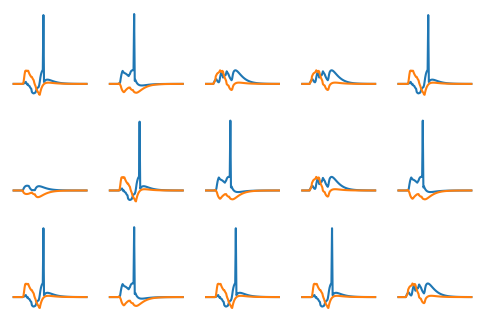

In [51]:
idx = 15
fig=plt.figure(dpi=100)
plot_voltage_traces(output[0][idx:], output[1][idx:])

In [52]:
y_data[idx:idx + 15].reshape((3,5))

tensor([[1, 1, 0, 0, 1],
        [0, 1, 1, 0, 1],
        [1, 1, 1, 1, 0]])